# Energy Consumption Forecast with XGBoost

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from pathlib import Path
from sklearn.metrics import mean_squared_error

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

## Loading the data

Dataset Source: https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption

We load the dataset (.csv) as Pandas Data Frame:

In [2]:
DATA_DIR = Path('data')
df = pd.read_csv(DATA_DIR / 'PJME_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

We plot the data to get a general idea:

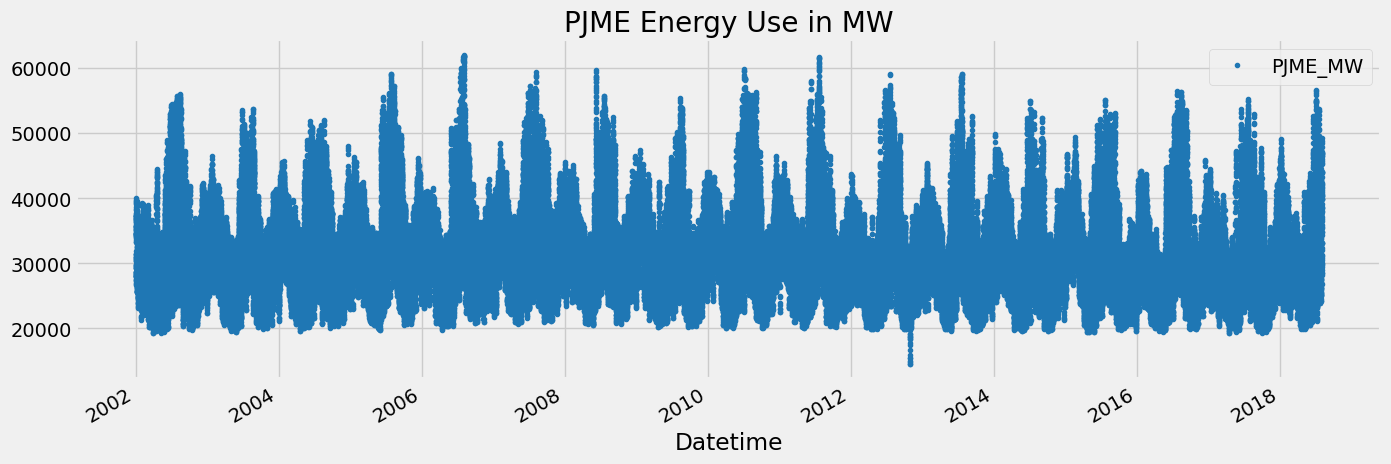

In [3]:
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='PJME Energy Use in MW')
plt.show()

Before making any prediction an exploratory analysis should be carried out on the data. For this series we can clearly observe seasonal patterns. These are some of the characteristics that should be taken into account:
- Trends
- Seasonal and nonseasonal cycles (related to seasons, quarters, months, days, hours...)
- Pulses and steps
- Are there outliers?
- Is there constant variance over time, or is the variance non-constant?


For example, let's see if there are any outliers:

### Outlier removal

We will detect outliers from observing data. Note that other methods (data deviation analysis) can be used to detect them.

<Axes: ylabel='Frequency'>

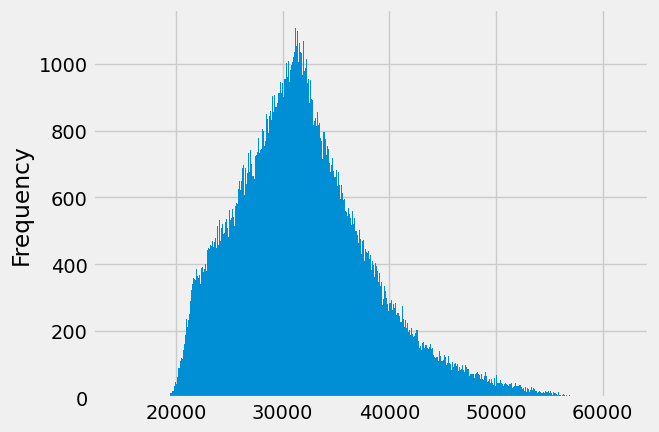

In [4]:
df['PJME_MW'].plot(kind='hist', bins=500)

<Axes: title={'center': 'Outliers'}, xlabel='Datetime'>

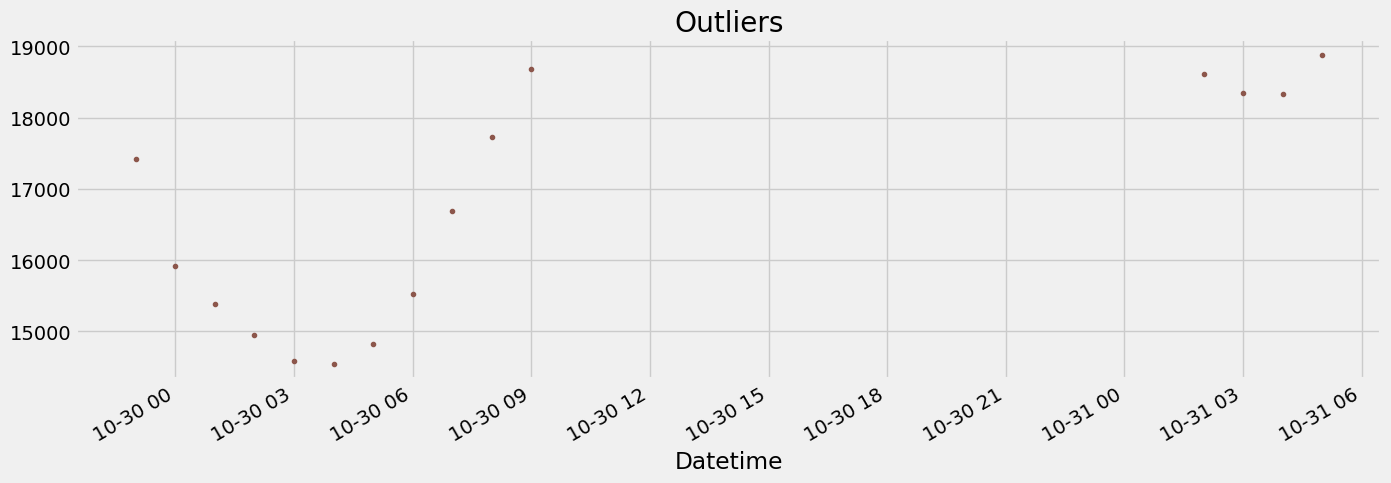

In [5]:
df.query('PJME_MW < 19_000')['PJME_MW'] \
    .plot(style='.',
          figsize=(15, 5),
          color=color_pal[5],
          title='Outliers')

In [6]:
df = df.query('PJME_MW > 19_000').copy()

We will do two different approaches:
- [Simple Training Method](#method1)
- [Time Series Cross Validation (+ using lag features)](#method2)

In [7]:
df2 = df.copy(deep=True) # save for later

<a name='method1'></a>
## SIMPLE TRAINING METHOD

There are several and more sophisticated ways of performing a model's evaluation (e.g. cross-validation), but as for this simple example, we will use the last 4 years for testing purposes. Anything prior to 2015 will be used for training.

### Train / Test Split

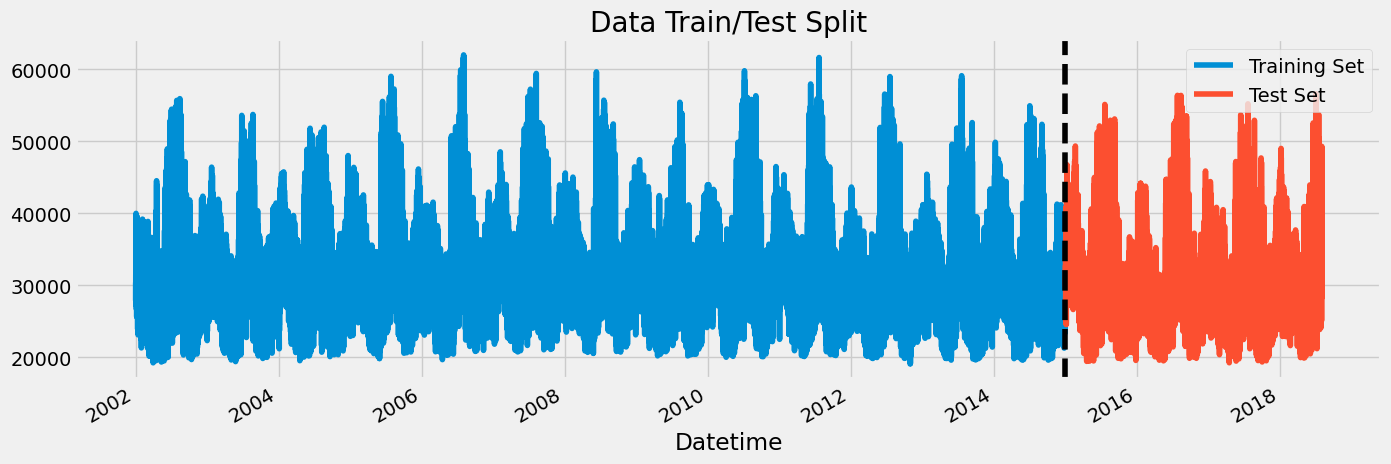

In [8]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

We can plot a week of data:

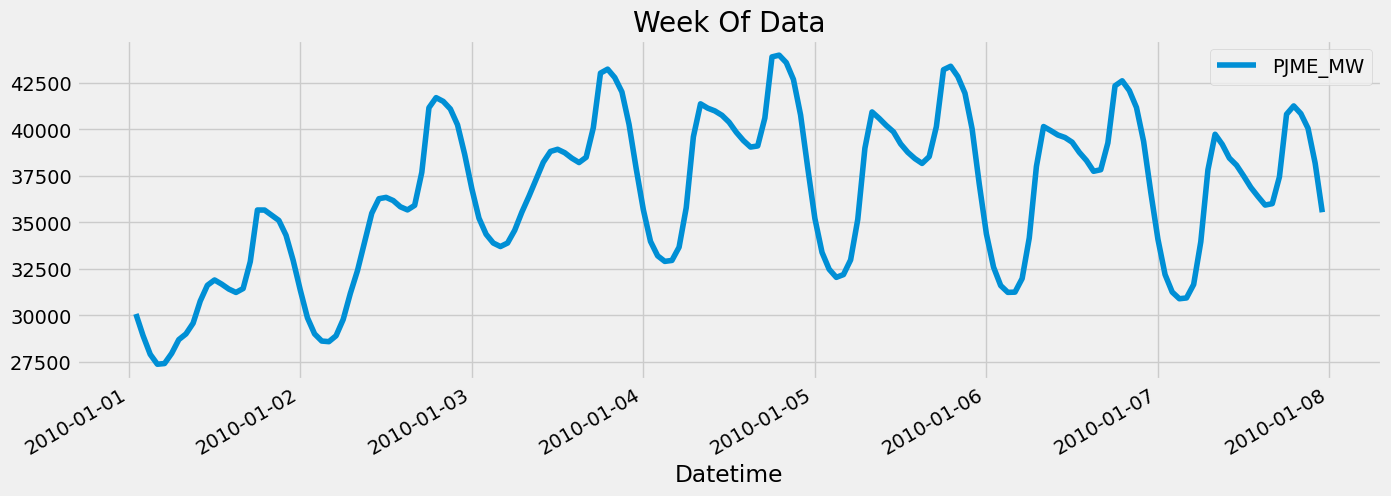

In [9]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')] \
    .plot(figsize=(15, 5), title='Week Of Data')
plt.show()

### Feature Engineering

XGBoost uses tabular data for training. We create the features that the model will use for training by using pandas date index. The features granularity will go from `year` up to `hour` granularity.

**Cyclical Features**

For some features, we will use cyclical features. For example, the `hour` feature will be transformed into two features: `hour_sin` and `hour_cos`. This is because the hour feature is cyclical, meaning that 23:00 is closer to 00:00 than to 12:00. This transformation will help the model understand this.

In [10]:
def cyclical_encoding(df: pd.DataFrame, col: str, max_val: int) -> pd.DataFrame:
    """
    Encode cyclical feature.
    """

    df = df.copy()
    df[col + '_sin'] = np.sin(2 * np.pi * df[col] / max_val)
    df[col + '_cos'] = np.cos(2 * np.pi * df[col] / max_val)
    return df

def add_cyclical_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Add cyclical features to dataframe.
    """

    cyclical_cols = ['hour', 'month', 'dayofweek']
    max_vals = [24, 12, 7]

    for col, max_val in zip(cyclical_cols, max_vals):
        df = cyclical_encoding(df, col, max_val)
    return df

def create_time_features(df: pd.DataFrame, cyclical: bool = True) -> pd.DataFrame:
    """
    Create time series features based on time series index.
    """

    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week.astype(int)

    if cyclical:
        df = add_cyclical_features(df)
    
    return df

In [11]:
df = create_time_features(df)

### Visualize our Feature / Target Relationship

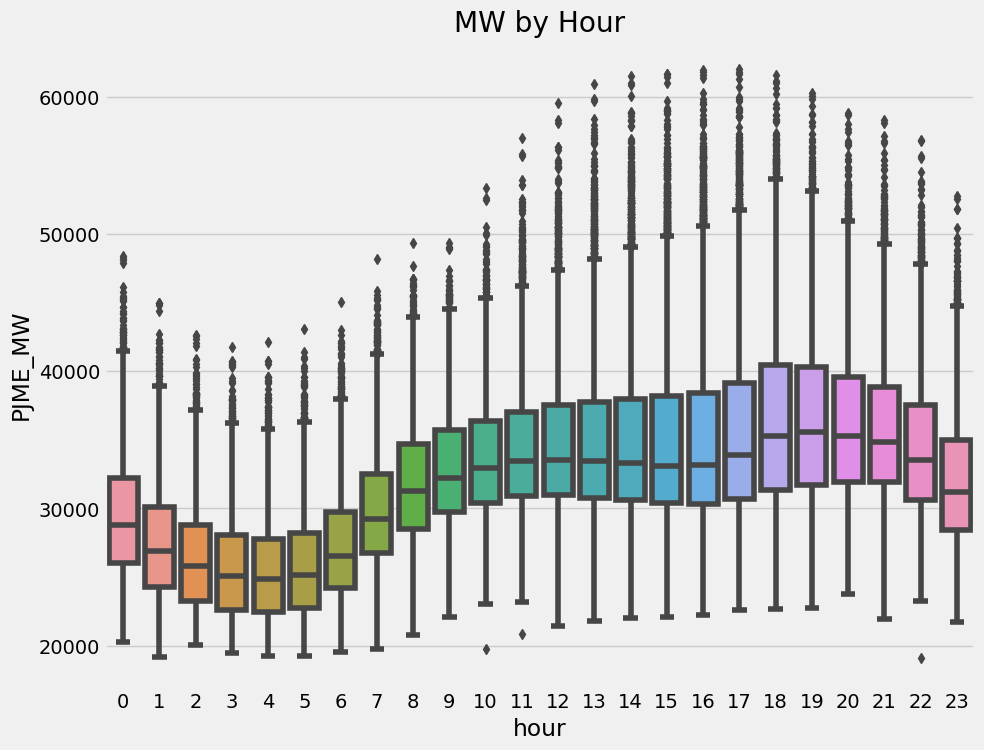

In [14]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='PJME_MW')
ax.set_title('MW by Hour')
plt.show()

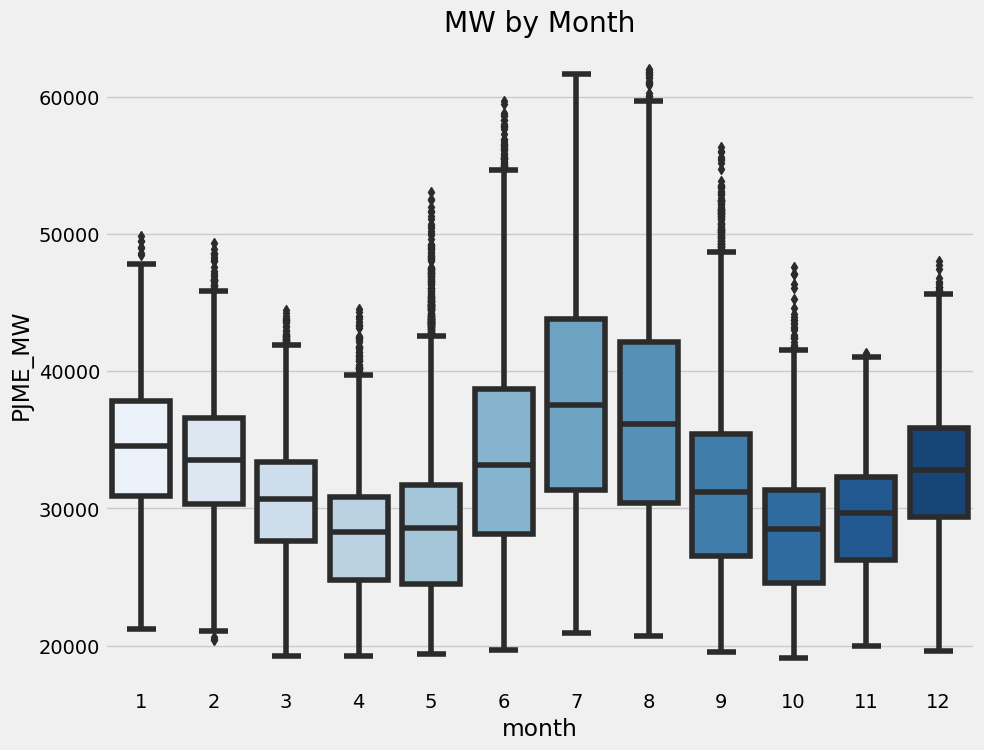

In [15]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='PJME_MW', palette='Blues')
ax.set_title('MW by Month')
plt.show()

In [16]:
train = create_time_features(train)
test = create_time_features(test)

FEATURES = [
    'dayofyear',
    'hour',
    'dayofweek',
    # 'quarter',
    'month',
    'year',
    'hour_sin',
    'hour_cos',
    'dayofweek_sin',
    'dayofweek_cos',
    'month_sin',
    'month_cos'
]
TARGET = 'PJME_MW'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

### Create and Train our Model

[Python library](https://xgboost.readthedocs.io/en/stable/)

[Paper](https://arxiv.org/abs/1603.02754)

In [18]:
# Initialize
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                       n_estimators=1000,
                       early_stopping_rounds=50, # if the model doesn't improve for 50 consec trees
                       objective='reg:squarederror',
                       max_depth=3,
                       learning_rate=0.01)
# Train
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:32606.72245	validation_1-rmse:31657.14675


[100]	validation_0-rmse:12582.66406	validation_1-rmse:11745.10814
[200]	validation_0-rmse:5798.49487	validation_1-rmse:5326.90535
[300]	validation_0-rmse:3871.48824	validation_1-rmse:3961.74790
[400]	validation_0-rmse:3412.98581	validation_1-rmse:3810.11192
[500]	validation_0-rmse:3260.92479	validation_1-rmse:3753.30617
[600]	validation_0-rmse:3183.47260	validation_1-rmse:3724.85889
[700]	validation_0-rmse:3131.84141	validation_1-rmse:3706.23850
[800]	validation_0-rmse:3088.18813	validation_1-rmse:3698.83629
[900]	validation_0-rmse:3052.32463	validation_1-rmse:3689.37976
[999]	validation_0-rmse:3022.71423	validation_1-rmse:3687.32229


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

### Feature Importance

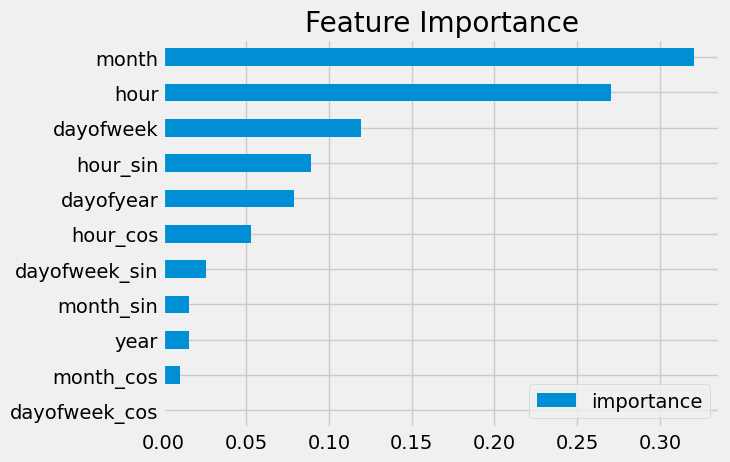

In [19]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

### Forecast on Test

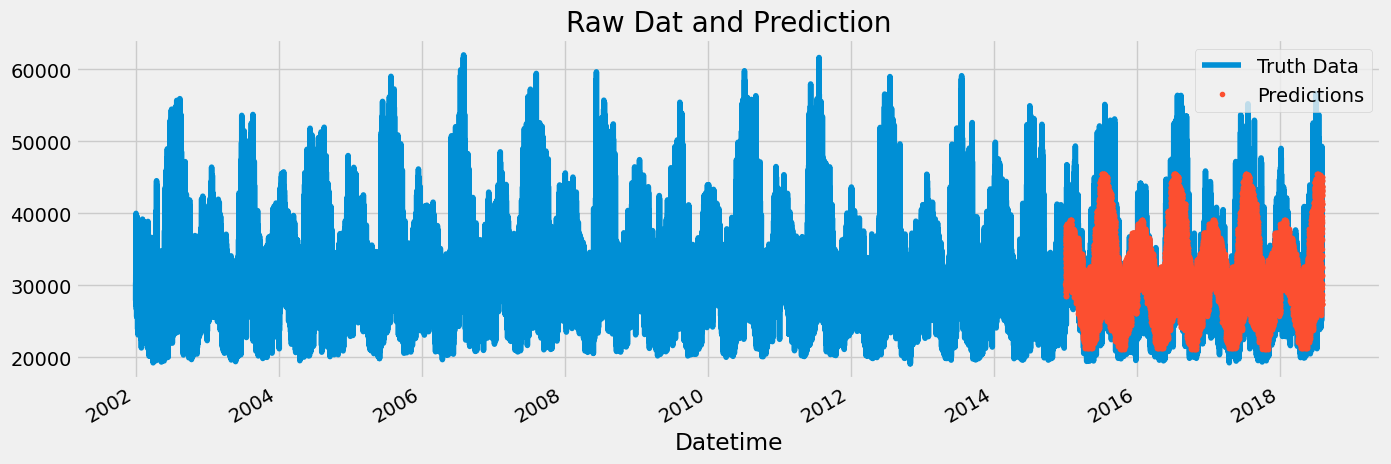

In [20]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['PJME_MW']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

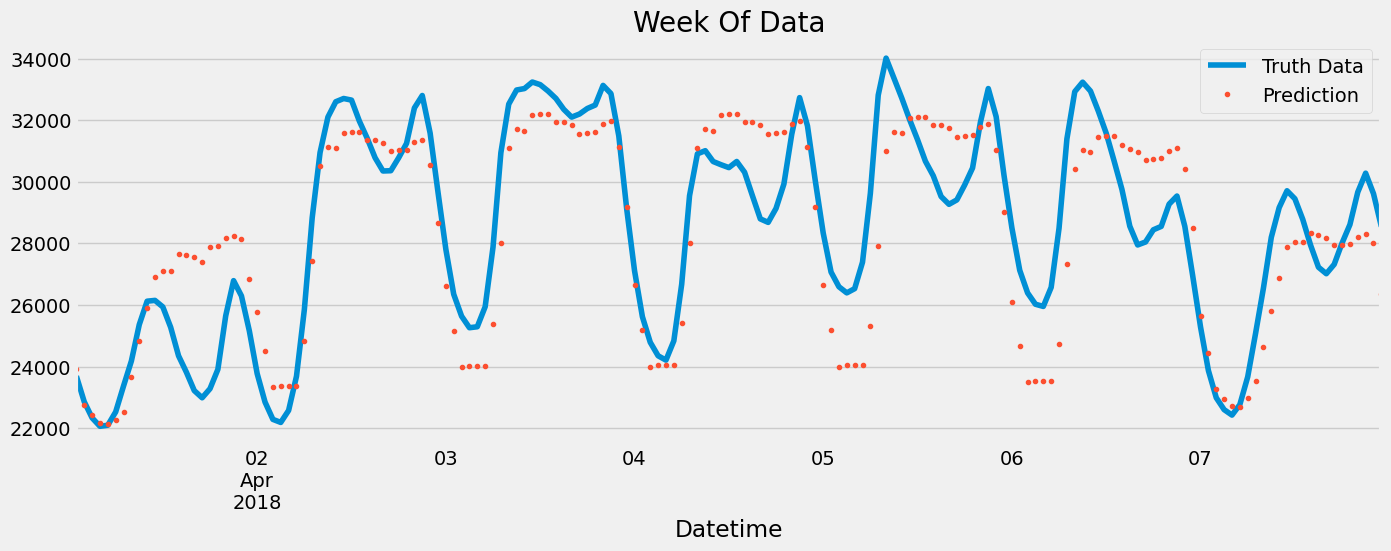

In [21]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['PJME_MW'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

### Score (RMSE)

In [23]:
print(f'RMSE Score on Test set: {np.sqrt(mean_squared_error(test["PJME_MW"], test["prediction"]))}')
print(f'MAPE on Test set: {np.mean(np.abs((test["PJME_MW"] - test["prediction"]) / test["PJME_MW"])) * 100}')
print(f'MPE on Test set: {np.mean((test["PJME_MW"] - test["prediction"]) / test["PJME_MW"]) * 100}')

RMSE Score on Test set: 3686.5534645117004
MAPE on Test set: 9.032519343150893
MPE on Test set: -2.5935511050846594


### Calculate Error

In [24]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2016-08-13    13213.004069
2016-08-14    12846.619873
2016-09-10    11814.658854
2016-09-09    11298.448079
2015-02-20    11095.978516
2016-08-12    10470.058268
2018-01-06    10426.851969
2015-02-21     9901.251139
2015-02-16     9664.311930
2018-01-07     9531.374756
Name: error, dtype: float64

<a id='name'></a>
## Time Series Cross Validation (+ using lag features)

In [25]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df2 = df2.sort_index()

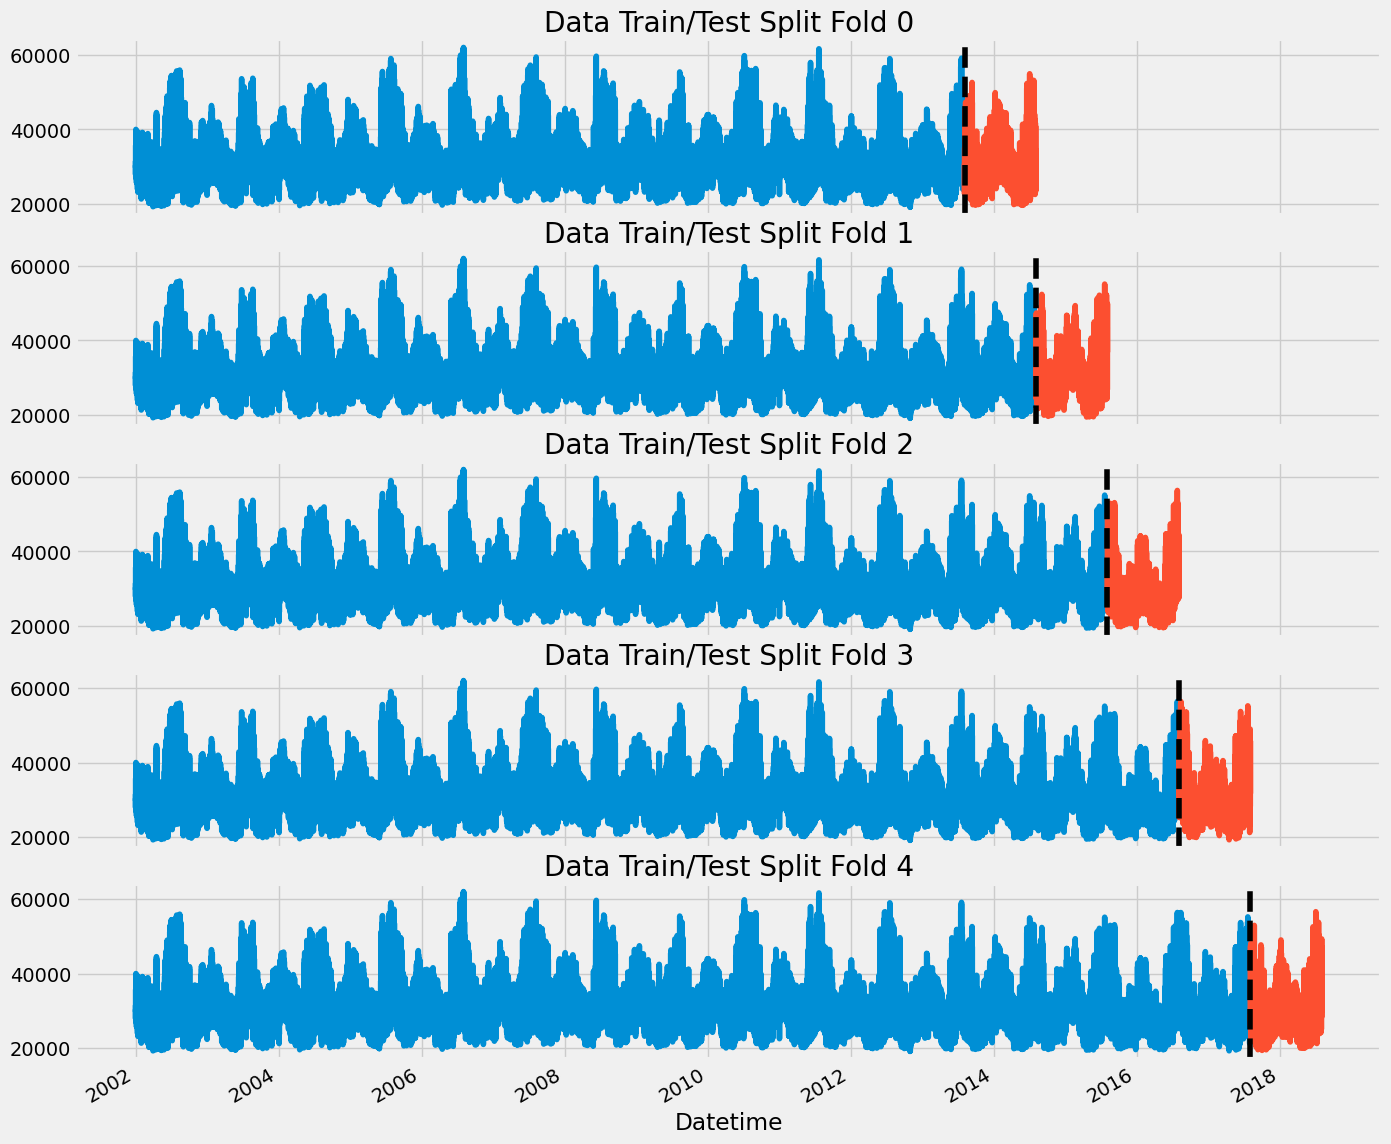

In [26]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df2):
    train = df2.iloc[train_idx]
    test = df2.iloc[val_idx]
    train['PJME_MW'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['PJME_MW'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

### Forecasting Horizon Explained

The forecast horizon is the length of time into the future for which forecasts are to be prepared. These generally vary from short-term forecasting horizons (less than three months) to long-term horizons (more than two years).

In [27]:
df2 = create_time_features(df2)

### Lag Features

Lag features refer to the values of previous time steps in the time series. They can help capture the autocorrelation present in the data, which is the relationship between the current value and its past values.

*Note: you can't add lag features further back than your forecasting horizon.*

In [28]:
def add_lags(df):
    target_map = df['PJME_MW'].to_dict()

    # Yearly lags
    df['yearly_lag_1'] = (df.index - pd.Timedelta(days=365)).map(target_map)
    df['yearly_lag_2'] = (df.index - pd.Timedelta(days=365*2)).map(target_map)
    df['yearly_lag_3'] = (df.index - pd.Timedelta(days=365*3)).map(target_map)

    # Trend
    df['yearly_incr_1'] = df['yearly_lag_1'] / df['yearly_lag_2']
    df['yearly_incr_2'] = df['yearly_lag_2'] / df['yearly_lag_3']
    return df

In [29]:
df2 = add_lags(df2)

### Training

In [31]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df2 = df2.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df2):
    train = df2.iloc[train_idx]
    test = df2.iloc[val_idx]

    train = create_time_features(train)
    test = create_time_features(test)

    FEATURES = [
        'dayofyear',
        'hour',
        'dayofweek',
        'month',
        'year',
        'hour_sin',
        'hour_cos',
        'dayofweek_sin',
        'dayofweek_cos',
        'month_sin',
        'month_cos',
        'yearly_lag_1',
        'yearly_lag_2',
        'yearly_lag_3',
        'yearly_incr_1',
        'yearly_incr_2'
    ]

    TARGET = 'PJME_MW'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:squarederror',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[0]	validation_0-rmse:32732.84883	validation_1-rmse:31953.54894
[100]	validation_0-rmse:12577.51461	validation_1-rmse:11862.82695
[200]	validation_0-rmse:5761.03808	validation_1-rmse:5296.00483
[300]	validation_0-rmse:3892.59263	validation_1-rmse:3871.25112
[400]	validation_0-rmse:3445.29886	validation_1-rmse:3756.40733
[415]	validation_0-rmse:3417.38223	validation_1-rmse:3758.48344
[0]	validation_0-rmse:32672.55705	validation_1-rmse:32138.99075
[100]	validation_0-rmse:12559.69478	validation_1-rmse:12210.75934
[200]	validation_0-rmse:5783.09125	validation_1-rmse:5587.63345
[300]	validation_0-rmse:3919.96705	validation_1-rmse:3861.63452
[400]	validation_0-rmse:3482.14973	validation_1-rmse:3561.70240
[500]	validation_0-rmse:3349.59888	validation_1-rmse:3466.02692
[600]	validation_0-rmse:3279.99774	validation_1-rmse:3421.50011
[700]	validation_0-rmse:3232.97398	validation_1-rmse:3392.65393
[800]	validation_0-rmse:3195.29082	validation_1-rmse:3362.98562
[900]	validation_0-rmse:3160.95733	v

In [32]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 3701.2429
Fold scores:[3754.314535057818, 3321.234799704091, 3503.928982229061, 3834.422452828104, 4092.3137649323307]


### Predicting the future

- Retraining on all data
- To Predict the future we need an emtpy dataframe for future date ranges.
- Run those dates through our feature creation code + lag creation

In [36]:
# Retrain on all data
df2 = create_time_features(df2)

FEATURES = [
        'dayofyear',
        'hour',
        'dayofweek',
        'month',
        'year',
        'hour_sin',
        'hour_cos',
        'dayofweek_sin',
        'dayofweek_cos',
        'month_sin',
        'month_cos',
        'yearly_lag_1',
        'yearly_lag_2',
        'yearly_lag_3',
        'yearly_incr_1',
        'yearly_incr_2'
        ]
TARGET = 'PJME_MW'

X_all = df2[FEATURES]
y_all = df2[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',
                       n_estimators=500,
                       objective='reg:squarederror',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[0]	validation_0-rmse:32404.35939
[100]	validation_0-rmse:12479.90226
[200]	validation_0-rmse:5810.26103
[300]	validation_0-rmse:3992.20554
[400]	validation_0-rmse:3582.35845
[499]	validation_0-rmse:3462.60548


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [37]:
df2.index.max()

Timestamp('2018-08-03 00:00:00')

In [38]:
# Create future dataframe
future = pd.date_range('2018-08-03','2019-08-01', freq='1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df2['isFuture'] = False
df_and_future = pd.concat([df2, future_df])
df_and_future = create_time_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [39]:
future_w_features = df_and_future.query('isFuture').copy()

#### Predict the future

In [40]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

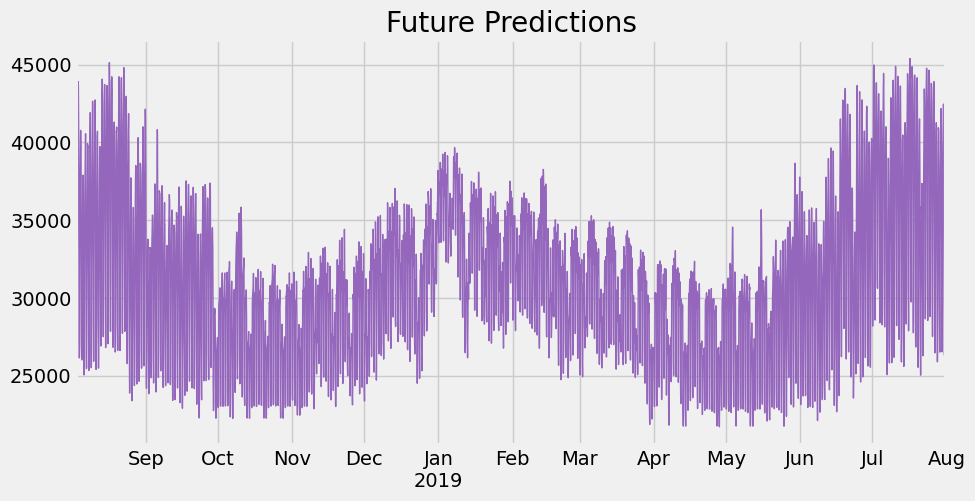

In [41]:
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()

## Next Steps
- More robust cross validation
- Add more features (weather forecast, holidays)

## Saving Model For later

In [42]:
# Save model as pickle
MODEL_DIR = Path('models')
MODEL_DIR.mkdir(exist_ok=True, parents=True)
reg.save_model(MODEL_DIR / 'xgb_model.pkl')

Loading and running the model:

<Axes: title={'center': 'Future Predictions'}>

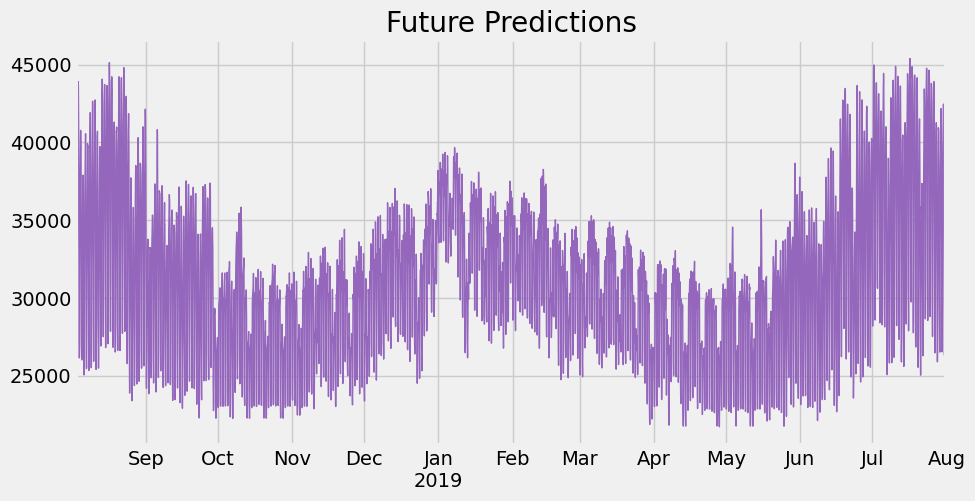

In [43]:
reg_new = xgb.XGBRegressor()
reg_new.load_model(MODEL_DIR / 'xgb_model.pkl')
future_w_features['pred'] = reg_new.predict(future_w_features[FEATURES])
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1, lw=1,
                               title='Future Predictions')